<a href="https://colab.research.google.com/github/richardtml/riiaa-20-aa/blob/master/notebooks/2b_cnn_eje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red convolucional: ejercicios

#### Bere & Ricardo Montalvo Lezama

**Básico.** Agregar al modelo una capa convolucional con 4 filtros (ver diagrama en Sec. Modelo).

**Intermedio.** Modificar el ejemplo para clasificar [CIFAR-10](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar) usando el Dataset de Pytorch.

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
# barras de progreso
from tqdm import tqdm

# directorio de datos
DATA_DIR = '../data'

# MNIST
MEAN = (0.1307)
STD = (0.3081)

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### 1.2 Auxiliares

In [2]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

![data](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/data.jpg)

### 2.2 Exploración

In [3]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


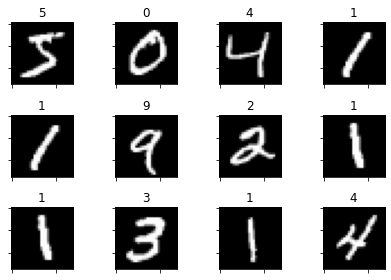

In [4]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

### 2.3 Cargadores de datos

#### Entrenamiento

In [5]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Prueba

In [6]:
# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


## 3 Modelo

![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/cnn_eje.jpg)

### 3.1 Definición de la arquitectura

In [7]:
# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        # tamaño de las capas
        C1 = 2
        FC1 = 10
        self.num_feats = 2 * 14 * 14
        # capas convolucionales
        self.cnn = nn.Sequential(
            # bloque conv1
            # [N, 1, 28, 28] => [N, 2, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=C1, kernel_size=3, padding=1),
            # [N, 2, 28, 28]
            nn.ReLU(),
            # [N, 2, 28, 28] => [N, 2, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # capas completamente conectadas
        self.cls = nn.Sequential(
            # bloque fc1
            # [N, 2x14x14] => [N, 10]
            nn.Linear(self.num_feats, FC1),
        )
    
    # metodo para inferencia
    def forward(self, x):
        # [N, 1, 28, 28] => [N, 2, 14, 14]
        x = self.cnn(x)
        # aplanamos los pixeles de la imagen
        # [N, 2, 14, 14] => [N, 2x14x14]
        x = x.view(-1, self.num_feats)
        # [N, 2x14x14] => [N, 10]
        x = self.cls(x)
        return x

### 3.2 Impresión de la arquitectura

In [8]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cls): Sequential(
    (0): Linear(in_features=392, out_features=10, bias=True)
  )
)


### 3.3 Prueba de la arquitectura

In [9]:
# inferencia con datos sinteticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([1, 10])


## 4 Entrenamiento

![train](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/train.jpg)

### 4.1 Ciclo de entrenamiento

In [10]:
# creamos un modelo
model = CNN()
# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 20
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)

E 0 loss=224.26 acc=20.31
E 1 loss=214.92 acc=37.19
E 2 loss=196.17 acc=56.02
E 3 loss=160.20 acc=68.28
E 4 loss=116.35 acc=76.41
E 5 loss= 87.19 acc=80.55
E 6 loss= 72.54 acc=81.95
E 7 loss= 61.22 acc=83.98
E 8 loss= 51.96 acc=86.56
E 9 loss= 47.65 acc=87.27
E10 loss= 42.64 acc=88.98
E11 loss= 41.93 acc=88.75
E12 loss= 35.44 acc=90.00
E13 loss= 37.28 acc=90.23
E14 loss= 34.88 acc=90.94
E15 loss= 38.01 acc=89.84
E16 loss= 31.59 acc=91.25
E17 loss= 29.06 acc=91.88
E18 loss= 28.02 acc=92.19
E19 loss= 29.83 acc=92.03


### 4.2 Gráfica de la pérdida

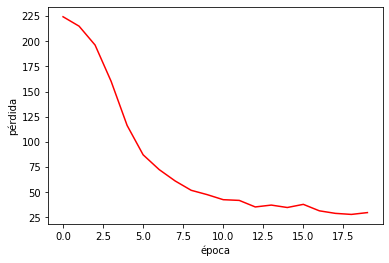

In [11]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

## 5 Evaluación

![eval](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/eval.jpg)

### 5.1 Conjunto de validación

In [12]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 91.67


### 5.2 Inferencia

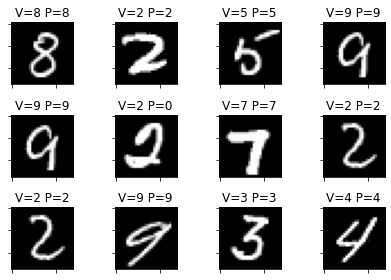

In [13]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)